# **AISaturdays Rental Challenge <font color="red"> SOLUTION </font>**

<img src="https://do3z7e6uuakno.cloudfront.net/uploads/event/logo/1112702/595053a7143adafce285b2e39ca04f1a.jpeg" width="300">

**Instructions:**

- You'll be using Python 3.
- You'll use Python's libraries: Pandas, MatPlotLib, Numpy.

**Completing the exercise, you´ll learn to:**
- Better use and understand Python NoteBooks.
- Be able to use python functions and additional libraries.
- Dataset:
 - Obtain the dataset and visualize the information contained.
 - Clean and normalise the dataset's information.
 - Represent and analyse the dataset's information.
- Correctly apply the Random Forest Algorithm.
- Improve the predictions using Hyperparameter Tunning, Feature engineering and Gradient Boosting

Let's get started!


In [ ]:
"""Install these two cells if needed. If it's teh first time installing them, restart the kernel before continuing :)"""


#import sys
#!{sys.executable} -m pip install graphviz

In [ ]:
#!pip install xgboost

#1.Importing libraries 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

#2. Dataset

Open the .csv ('AB_NY_2019.csv') and display the first few lines.

In [2]:
#Two lines of code
df = pd.read_csv('AB_NY_2019.csv', header=0)

1. Show the number of features and examples in the dataset.

In [3]:
#One-liner code
df.columns

Index(['Unnamed: 0', 'id', 'name', 'host_id', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'price'],
      dtype='object')

2. Obtain the (dtypes) of the features and the number of rows.

In [4]:
#One-liner code
df.dtypes

Unnamed: 0                          int64
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
price                               int64
dtype: object

### Variables



* **Id/name:**  Identifier and name of the property.

* **host_id/host_name:** Identifier and host name.

* **neighbourhood_group/neighbourhood:** Area and neighbourhood of the property. Each Area is a group of neighbourhoods.
* **latitude/longitude:** Latitude and longitude of the property.

* **room_type:** The type of property offered. It can be a single room, a shared apartment or a whole property.

* **minimum_nights:**  Minimum number of nights to stay.

* **number_of_reviews:**  Total number of reviews.

* **last_review:**  Date of the last review.

* **reviews_per_month:** Monthly number of reviews. It's rarely *int* and it can be less than one..

* **calculated_host_listings_count:** Total number of properties the host is offering.

* **availability_365:** Yearly availability of the flat in number of days: maximum is 365 days ( the whole year).

* **price:** Our target variable! The price of the proeprty in dollars.



Is this truly a regression or classification problem? Why?:

3. Before analyzing the dataset, we need to transform the dates (last_review) into something with which we can work. Pandas has a specific format for this, datetime. Change last_review to datetime.

In [5]:
# One-liner code
from datetime import datetime
df["last_review"] = pd.to_datetime(df["last_review"], format='%Y-%m-%d')

4. To analyse the data we also need to lnow how much information we're missing. Use .isnull() to find out which feature is missing more values. 

In [6]:
# One-liner code
df.isnull().sum()

Unnamed: 0                           0
id                                   0
name                                 4
host_id                              0
host_name                           17
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
last_review                       6772
reviews_per_month                 6772
calculated_host_listings_count       0
availability_365                     0
price                                0
dtype: int64

5. Finally, we need to drop the features that are only identifiers and are not useful for predictions.

In [7]:
# One-liner code
df = df.drop(["host_id", "id", "Unnamed: 0", "host_name", "name"], axis=1)

6. All ready! We can analyse the distribution of data with .describe()

In [8]:
# One-liner code
df.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
count,32759.000000,32759.000000,32759.000000,32759.000000,25987.000000,32759.000000,32759.000000,32759.000000
mean,40.728968,-73.952465,7.131475,23.240911,1.383150,7.223175,113.116090,154.312983
std,0.054479,0.045704,21.236959,44.354050,1.699714,33.275291,131.687842,256.571284
min,40.499790,-74.240840,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,40.690150,-73.983130,1.000000,1.000000,0.190000,1.000000,0.000000,69.000000
50%,40.723180,-73.955800,3.000000,5.000000,0.730000,1.000000,45.000000,107.000000
75%,40.763155,-73.936540,5.000000,24.000000,2.030000,2.000000,226.000000,178.000000
max,40.913060,-73.712990,1250.000000,607.000000,58.500000,327.000000,365.000000,10000.000000


### Cleaning and normalization of the dataset
![texto alternativo](https://i.imgur.com/8u4xTI7.png)

This dataset contains incomplete information that we need to impute to be able to use it for the rpediction of the property prices.
We also need to transform *last_review* if we eant to use it for the prediction, we cannot use it directly as a date.
For this processing we'll use Pandas functions, you already have a cheatsheet from the previous session, but take a look at this other [cheatsheet](https://assets.datacamp.com/blog_assets/PandasPythonForDataScience.pdf).

7. Find the number of rows that do not have reviews and hence have empty values for last_review and reviews_per_month.

In [9]:
# One-liner code
df[["last_review", "reviews_per_month"]].isnull().sum()

last_review          6772
reviews_per_month    6772
dtype: int64

8. We need to complete this information if we don't want to disregard the rest of the features. Fill in the NaNs of reviews_per_month with 0 (We'll take last_review later on).

In [10]:
# One-liner code
df["reviews_per_month"].fillna(0, inplace=True)

9. Time to transform the variable *last_review*. It's a date, which makes it hard to work with. Let's first complete the entries that do not have a last date. Replace these NaNs with the first historical revision of the dataset.

In [11]:
# Two lines of code
first_review = df["last_review"].min()
df["last_review"].fillna(first_review, inplace=True)

10. Now that we don't have empty values we can change the last_review variable to something more useful. We look for smaller values to correspond to old or no reviews, while larger values correspond to more recent reviews.
We can use the toordinal() function to find the number of days that have elapsed since day 1 of year 1, but those are still too large numbers that don't follow the distribution we're looking for.

Gets last_reviews to represent the number of days that have elapsed since the first historical review was done. 

In [12]:
# One-liner code
df["last_review"] = df["last_review"] - first_review
df["last_review"] = df["last_review"].dt.days.astype(int) # (another way of doing it)

11. To visualize the distribution of dates, generate a graph showing the variable last_reviews.

(array([6.7780e+03, 1.1000e+01, 2.3000e+01, 6.0000e+01, 2.1500e+02,
        1.1510e+03, 1.6980e+03, 1.5720e+03, 2.6200e+03, 1.8631e+04]),
 array([   0. ,  299.6,  599.2,  898.8, 1198.4, 1498. , 1797.6, 2097.2,
        2396.8, 2696.4, 2996. ]),
 <BarContainer object of 10 artists>)

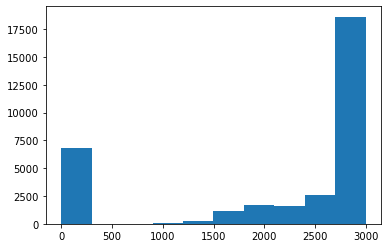

In [13]:
# One-liner code
plt.hist(df["last_review"])

It seems there are two well distinguished groups. What do you think is it causing this?

#### Study of the variable to predict and noise elimination

12. When it comes to predicting the price, it is much more favorable if we first transform and analyze the variable we are looking for to make it easier to predict.

First, let's see how the price of the offers is distributed. Generate a graph showing the price of the bids. Here's a [hint.](https://seaborn.pydata.org/generated/seaborn.distplot.html).

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


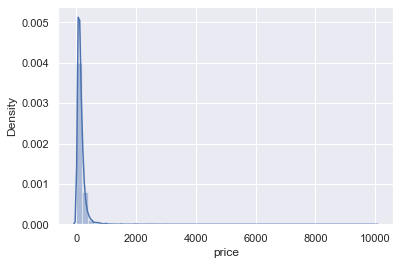

In [14]:
# One-liner code
import seaborn as sns, numpy as np
sns.set_theme()
ax = sns.distplot(df["price"])

We have a variable that follows a log-normal distribution. We can transform it into a normal distribution by applying log1p(), a function that responds to the following equation:

𝑦=𝑙𝑜𝑔(𝑥+1)

This makes the price easier to predict, as it has a normal distribution.


13. Let's visualize this transformation. Generates another price graph after applying the log1p() function.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


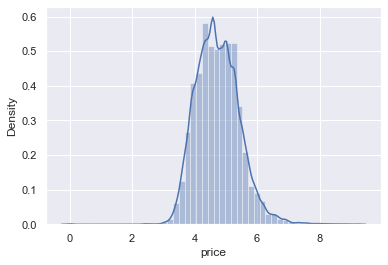

In [15]:
# One-liner code
df['price'] = np.log1p(df['price'])
ax = sns.distplot(df["price"])

Now we have a much more appropriate distribution to make predictions. However, there are still many outliers that add noise to the sample.

14. Above and below what values is this noise present? Eliminates from the dataframe those values that do not fit into the normal distribution. 

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
0,Brooklyn,Bushwick,40.69987,-73.91821,Private room,1,28,2995,2.75,1,36,4.248495
1,Manhattan,Hell's Kitchen,40.76247,-73.99294,Private room,4,77,2977,1.81,1,21,5.484797
2,Manhattan,Midtown,40.76152,-73.97176,Entire home/apt,5,2,2967,1.00,1,132,6.109248
3,Manhattan,Upper East Side,40.77988,-73.95482,Entire home/apt,4,58,2976,4.26,1,158,5.991465
4,Brooklyn,Williamsburg,40.71303,-73.95580,Entire home/apt,2,28,2980,0.61,1,170,4.700480


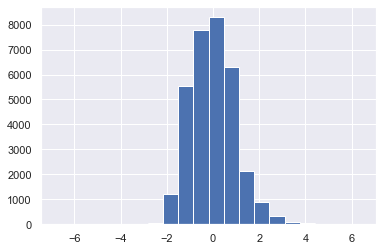

In [16]:
# Two lines of code
zscore = stats.zscore(df["price"])
plt.hist(zscore, bins=20)
# from the z-score plot, we can see that values approximately outside
# +-3 standard deviations can be considered as outliers (visual check)
df = df.assign(zscore=zscore)
df = df.loc[(df["zscore"] < 3) & (df["zscore"] > -3)].drop("zscore", axis=1)
df.head()

15. Now, rebuild the price plot and price log1p (use the same code as before, or put it in a [subplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html )).

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


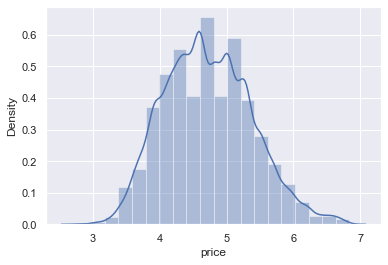

In [17]:
# Four lines of code
ax = sns.distplot(df["price"], bins=20)

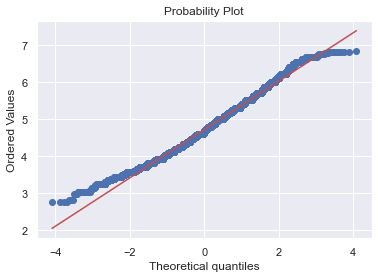

In [18]:
# Another way to check if data are normally distributes is with a qqplot
stats.probplot(df["price"], dist="norm", plot=plt)
plt.show()

# A better fit would be to consider data from -2 to +2 standard deviations

#### Variable exploration

We are going to explore a little more the rest of the variables that can affect the price of an offer.

17. Let's start by creating a histogram of the different areas of the city and the number of offers in each of them (you may need to enlarge the graph)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='neighbourhood_group', ylabel='calculated_host_listings_count'>

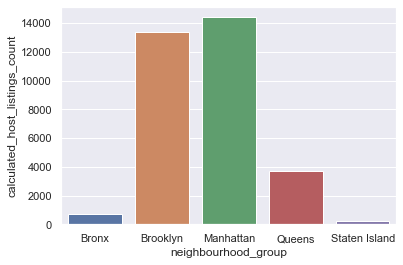

In [19]:
# Three lines of code
groups = df.groupby("neighbourhood_group")['calculated_host_listings_count'].count().reset_index()
sns.barplot(groups.neighbourhood_group, groups.calculated_host_listings_count)

18. Now create a map of the offered apartments with latitude and longitude (extra points if you color them by areas or neighborhoods). It's best to do it in a subplot so you can control the size of the map.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

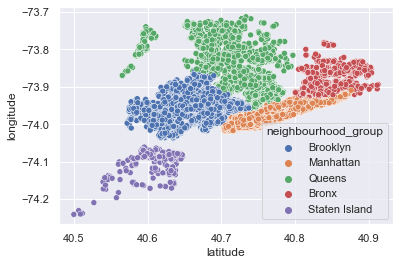

In [20]:
# Two lines of code
sns.scatterplot(df["latitude"], df["longitude"], hue = df["neighbourhood_group"])

19. We are now going to generate another histogram, this time with the type of room offered (It is also a good idea to adjust the size of the graph).

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='room_type', ylabel='calculated_host_listings_count'>

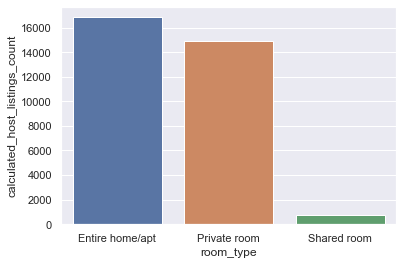

In [21]:
# Three lines of code
groups = df.groupby("room_type")['calculated_host_listings_count'].count().reset_index()
sns.barplot(groups.room_type, groups.calculated_host_listings_count)

#### Variable Transformation

We can apply the same process that we applied to the price variable to our input variables and thus achieve a more comfortable distribution for the search methods.

Apply the log1p() transformation to minimum_nights, generating the before and after plots and compare them.

In [22]:
# Three lines of code
df["minimum_nights"] = np.log1p(df["minimum_nights"])

21. Repeat the process, this time with reviews_per_month. Is transformation relevant?

In [23]:
# Three lines of code
df["reviews_per_month"] = np.log1p(df["reviews_per_month"])

#### Study of availability in number of days (0.365)

22. Let's start by representing the availability in a distplot(). Since we know the limits of this variable, it is best to limit the range of the graph and make it larger.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='availability_365', ylabel='Density'>

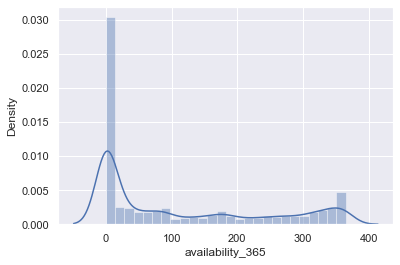

In [24]:
# Four lines of code
sns.distplot(df.availability_365)

#### Add artificial variables

It has been seen in the scatterplot above that there seem to be two groups, one available most of the year and another only a few days.

It is also intuited that those sites that do not have reviews... How do they not give much confidence? ;)

Add three categories that measure if the apartment is available all year round, if its availability is very low (less than 12 days a year), and if it has no reviews.

23. Add three categories that measure if the apartment is available all year round, if its availability is very low (less than 12 days a year), and if it has no reviews.

In [25]:
# Three lines of code
df["all_year_round"] = 0
df["all_year_round"].loc[df["availability_365"]==365] = 1
df["low_availability"] = 0
df["low_availability"].loc[df["availability_365"]<=12] = 1
df["no_reviews"] = 0
df["no_reviews"].loc[df["number_of_reviews"]==0] = 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

24. We are going to generate a heatmap that shows the relationship between all the input variables and price. It uses corr() and seaborn's heatmap() function.

<AxesSubplot:>

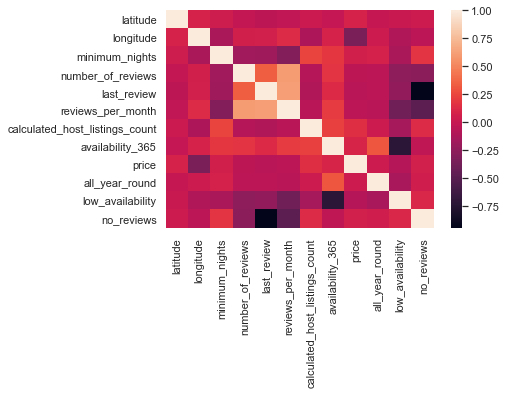

In [26]:
# One line of code
sns.heatmap(df.corr())

#### Pass categorical variables to one_hot

25. To make the categorical features easier to interpret by the model, we are going to transform them into a OneHotEncoding. Use pandas get_dummies() function (you should have 236 columns left)

In [27]:
# Two lines of code
df = pd.get_dummies(df)

# Models, models, models

With all the exploration, analysis and data cleaning done, we move on to the fun part: The models!

We start by importing all the classes that we are going to need to find a good predictive model:

In [28]:
from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

26. Split the dataset into X_train, X_test, y_train and y_test using train_test_split(). Don't forget not to include price in the training set.

In [29]:
# Three lines of code
X = df[[x for x in df.columns if x!="price"]]
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

27. We are going to use cross_validation to train our model, using Kfold to find the score. Implement a Kfold that performs 5 splits and calculates the mean error and deviation of a RandomForestRegressor without changing its parameters (yet). [Hint](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [30]:
# Three lines of code
model = RandomForestRegressor()
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error",
                         cv=cv, n_jobs=-1)

28. When using a RandomForestRegressor, what hyperparameters were we using? List all the parameters used by this model (it uses the get_params() function and the pprint library)

In [31]:
from pprint import pprint
## Two lines of code
pprint(model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


We can adjust all of these parameters to improve the accuracy of our model. One way to find which combination works best is to use a GridSearchCV, which tests models with many different combinations and calculates their score to find the best brute force model. For this, you have to pass a list of values for each parameter, and GridSearchCV will try all of them. [More information](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

29. Delimit what values you want each parameter to have, and include each of these lists in a dictionary to be able to execute the GridSearchCV. Note the possible values for each of the parameters.

In [32]:
# Eight lines of code

# heavy! Here we can choose all the parameters we want to investigate. Only n_trees and and max_depth are choses here.
n_estimators = [20, 60, 100, 140]
max_depth = [2, 6, 10, 12]
parameters = {'n_estimators':n_estimators, 'max_depth':max_depth}

30. Now we can implement a GridSearchCV. To make it faster, a version is used that does not test all possible combinations, but only a few random ones (hence its name, RandomizedSearchCV). Implement it, taking into account that it has as parameters the model to be adjusted and the dictionary that we have defined before, among others. This step may take a few minutes as you have to adjust many models to find the best one. Here is the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) for the RandomizedSearchCV.

In [33]:
# Two lines of code
model = RandomForestRegressor()
clf = GridSearchCV(model, parameters) # or use randomised search
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 6, 10, 12],
                         'n_estimators': [20, 60, 100, 140]})

31. Finally, find the mean squared error and 𝑅2 of the best model you have created.

In [34]:
# Six lines of code
from sklearn.metrics import mean_squared_error, r2_score
optimal_model = clf.best_estimator_
feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]
pred_test = optimal_model.predict(X_test)
pred_train = optimal_model.predict(X_train)
r2_test = r2_score(y_test, pred_test)
r2_train = r2_score(y_train, pred_train)
mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)
print(f"training error: mse = {mse_train}, r2 = {r2_train}")
print(f"testing error: mse = {mse_test}, r2 = {r2_test}")

# The error in testing is significantly higher which may be an indication of overfitting

training error: mse = 0.09468270562811008, r2 = 0.7769669763695688
testing error: mse = 0.15672275856619025, r2 = 0.6389365677386166


Now, to improve that score! You can try:

- Remove features that are not relevant to the prediction
- Implement Gradient boosting using XBoost or Adaboost, among others
- Tune hyperparameters manually to arrive at better models
- Use a Tree Interpreter to see which decision trees are most important

Let's see who achieves the best score! 🚀

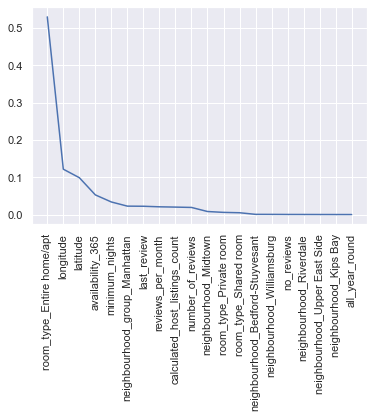

In [35]:
importance = {x:y for x,y in zip(feature_names, optimal_model.feature_importances_)}
importance = dict(sorted(importance.items(), key = lambda x: x[1], reverse=True))

# Even though the default method implemented in RF for variable importance is not the most accurate,
# one can see that some of the hot encoded variables play a role in the prediction
plt.plot(list(importance.keys())[:20], list(importance.values())[:20])
plt.xticks(rotation='vertical')
plt.show()

In [36]:
# Take the top 20 features and train the model

top_20_features = list(importance.keys())[:20]
X_train = X_train[top_20_features]
X_test = X_test[top_20_features]

In [37]:
# xgboost: play aorund with randomisedsearch, cross validation
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error, r2_score
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',
                             colsample_bytree = 0.3,
                             learning_rate = 0.1,
                             max_depth = 10,
                             alpha = 1,
                             n_estimators = 100)

xgb_model.fit(X_train, y_train)
xgb_pred_test = xgb_model.predict(X_test)
xgb_pred_train = xgb_model.predict(X_train)

In [38]:
r2_test = r2_score(y_test, xgb_pred_test)
r2_train = r2_score(y_train, xgb_pred_train)
mse_train = mean_squared_error(y_train, xgb_pred_train)
mse_test = mean_squared_error(y_test, xgb_pred_test)
print(f"training error: mse = {mse_train}, r2 = {r2_train}")
print(f"testing error: mse = {mse_test}, r2 = {r2_test}")

training error: mse = 0.09323216472800178, r2 = 0.7803838466491473
testing error: mse = 0.1544347959749783, r2 = 0.6442076568492625


In [ ]:
dmatrix = xgb.DMatrix(data = X_train, label = y_train)

params = {"objective":"reg:squarederror",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 10,
          'alpha': 1,
          'n_estimators': 100}

xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

plot_tree(xg_reg, num_trees = 0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()